In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.beam_utils import gaussian_beam
import tdwg_lib.ftutils_torch as ftutils

## Main

In [3]:
# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0
neff = 1.8 # effective index of slab mode

# x-axis
Lx = 500 # width of simulation area in um (transverse dimension)
Nx = 2**9 # number of pixels in transverse dimensions
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
dz = 10. # propagation step in z-direction in um
Lz = 10000 # length of device in propagation-direction in um
Nz = int(np.floor(Lz/dz))
z_axis = (torch.arange(Nz)+1)*dz

In [4]:
# Set up the split step solver which will integrate the PDE
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)

## Define refractive index distribution and inputs

Text(0.5, 1.0, 'Refraction index distribution of Y-splitter')

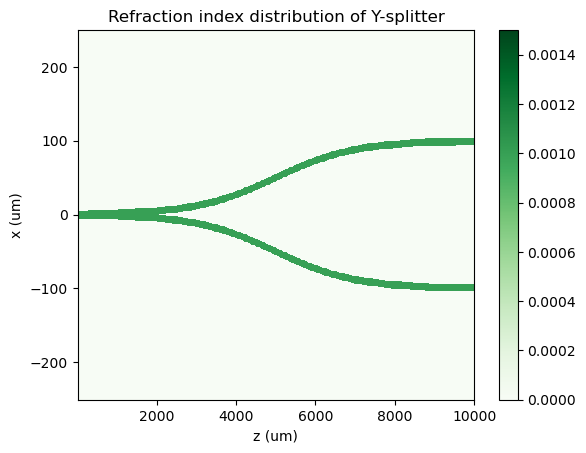

In [5]:
deflection = 100 # deflection of Y-splitter in transverse direction
scale = 1000 # scale of Y-splitter in propagation direction
wg_radius = 5 # width of waveguides making up Y-splitter
xx, zz = torch.meshgrid(x_axis, z_axis, indexing = 'ij')
dn_prog = torch.zeros_like(xx)
dn_prog[torch.abs( xx - deflection * torch.sigmoid((zz - Lz/2)/scale) ) < wg_radius] = 1e-3
dn_prog[torch.abs( xx + deflection * torch.sigmoid((zz - Lz/2)/scale) ) < wg_radius] = 1e-3

plt.pcolormesh(z_axis, x_axis, dn_prog, cmap = 'Greens', vmin = 0, vmax = 1.5e-3)
plt.colorbar()
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title('Refraction index distribution of Y-splitter')

C:\Users\MartinStein\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\MartinStein\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Amplitude profile of input Gaussian beam')

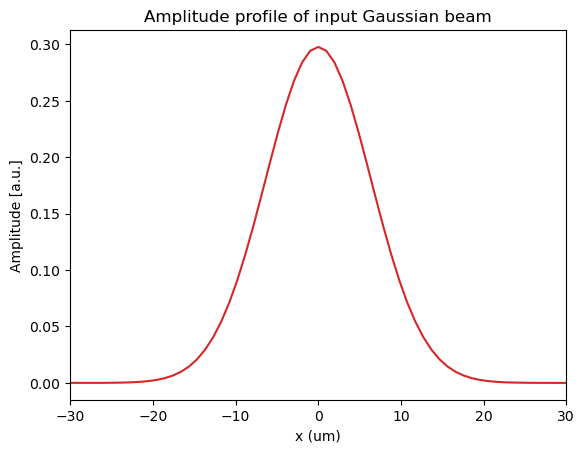

In [6]:
mode = gaussian_beam(x_axis, x_center = 0, w0 = 9)
plt.plot(x_axis, mode, c='tab:red')
plt.xlim(-30, 30)
plt.xlabel('x (um)')
plt.ylabel('Amplitude [a.u.]')
plt.title('Amplitude profile of input Gaussian beam')

## Simulat and plot results

In [7]:
E_out = bpmsolver.run_simulation(torch.vstack([mode]), dn_prog.T, monitor=True)

C:\Users\MartinStein\OneDrive - Yale University\Work\Github\2D-waveguide-demo-code\tdwg_lib\split_step_solver.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


Text(0.5, 1.0, 'Intensity distribution of Gaussian beam propagating through Y-splitter')

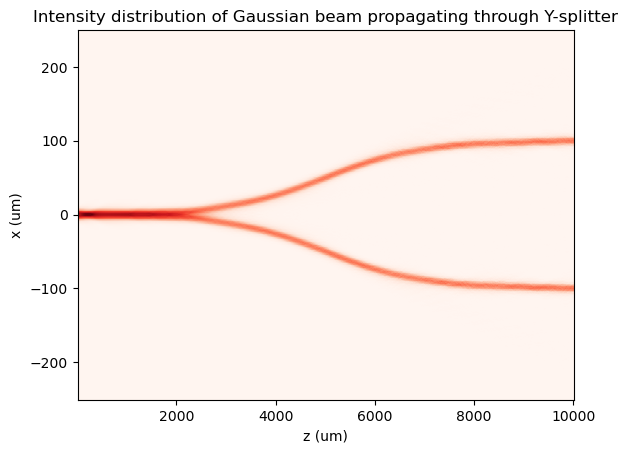

In [8]:
ind_mode = 0
plt.pcolormesh(z_axis, x_axis, bpmsolver.Emat_x[:,ind_mode].abs().square().T, cmap = 'Reds')
plt.xlabel('z (um)')
plt.ylabel('x (um)')
plt.title(f'Intensity distribution of Gaussian beam propagating through Y-splitter')